# Introduction

In this session, we'll explore some advanced topics in machine learning (ML): ensemble models, model interpretability, and hyperparameter tuning. These concepts will be introduced theoretically and then applied to hands-on examples.

Throughout the session, we'll use the Lending Club dataset, focusing on predicting loan defaults.

### Agenda:

0. **Decision trees**
1. **Ensemble models**
2. **Model interpretability and explainability frameworks**
3. **Hyperparameter tuning**
---


### Set up

#### User-specified parameters

In [1]:
python_material_folder_name = "python-material"

#### Import libraries

In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Check if in Google Colab environment
try:
    from google.colab import drive
    # Mount drive
    drive.mount('/content/drive')
    # Set up path to Python material parent folder
    path_python_material = rf"drive/MyDrive/{python_material_folder_name}"
        # If unsure, print current directory path by executing the following in a new cell:
        # !pwd
    IN_COLAB = True
except:
    IN_COLAB = False
    # If working locally on Jupyter Notebook, parent folder is one folder up (assuming you are using the folder structure shared at the beginning of the course)
    path_python_material = ".."

#### Import data

In [3]:
# Read data that was exported from previous session
df = pd.read_csv(f"{path_python_material}/data/2-intermediate/df_out_dsif5.csv").sample(1000)
print(f"Shape: {df.shape}")
df.head()

Shape: (1000, 160)


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,hardship_status_filled,last_pymnt_amnt_log,last_pymnt_amnt_capped,loan_id_extracted,emp_title_clean,emp_title_manager,Job Title,Category,int_rate_clean,term_numeric,debt_to_income,interest_per_loan_amnt,loan_amnt_log,grade_encoded,loan_amnt_std,annual_inc_std,loan_amnt_norm,annual_inc_norm,loan_default
52485,155874920,15000.0,15000.0,15000.0,60 months,17.74%,378.79,C,C5,Information Security Administrator,7 years,RENT,60000.0,Source Verified,Jul-2019,Current,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,104xx,NY,4.74,0.0,Jul-2015,685.0,689.0,0.0,NaN,NaN,4.0,0.0,8712.0,83%,4.0,w,13320.90,13320.90,3758.330000,3758.33,1679.10,2079.23,0.0,0.0,0.0,May-2020,378.79,Jun-2020,May-2020,749.0,745.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,8712.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,1.0,2.0,3509.0,83.0,10500.0,0.0,0.0,0.0,2.0,2178.0,1788.0,83.0,0.0,0.0,NaN,48.0,11.0,11.0,0.0,11.0,NaN,17.0,NaN,0.0,4.0,4.0,4.0,4.0,0.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,1.0,100.0,50.0,0.0,0.0,10500.0,8712.0,10500.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NO_HARDSHIP,5.939618,378.79,155874920,information security administrator,False,NaN,NaN,0.1774,60,0.250000,13305.00,9.615872,2,-0.035104,-0.229629,0.363868,0.005455,False
25686,73570499,10000.0,10000.0,10000.0,36 months,6.97%,308.64,A,A3,Senior Associate,5 years,RENT,66000.0,Source Verified,Mar-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,981xx,WA,23.98,0.0,Sep-2006,685.0,689.0,0.0,29.0,NaN,22.0,0.0,9217.0,46.6%,26.0,w,0.00,0.00,10543.638306,10543.64,10000.00,543.64,0.0,0.0,0.0,Jan-2017,7758.14,NaN,Dec-2019,789.0,785.0,0.0,29.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0

In [4]:
# Selected features
features = ['fico_range_high', 'fico_range_low', 'annual_inc', 'dti']
X = df[features]
y = df['loan_default']

# 0. Decision trees

A **Decision Tree** is a supervised learning algorithm used for both classification and regression tasks. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

The decision tree algorithm works by recursively splitting the dataset into smaller subsets based on feature values. The "tree" is built by selecting features that best split the data at each node (branch point). These splits are made to maximize the **information gain** or minimize the **Gini impurity** (for classification tasks).

-   **Root Node:** The top-most node that contains the entire dataset.
-   **Internal Nodes:** Points where data is split based on a feature condition.
-   **Leaf Nodes:** The terminal nodes of the tree where a final decision is made (classification or regression).

See visual example [here](https://en.wikipedia.org/wiki/Decision_tree_learning#/media/File:Decision_Tree.jpg)


## 0.1\. **Building a Simple Decision Tree (Using the Lending Club Dataset)**

Let's build a simple Decision Tree classifier on the Lending Club dataset.

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [6]:
# Initialize a Decision Tree Classifier with a max depth of 3 (for simplicity)
decision_tree = DecisionTreeClassifier(max_depth=3, 
                                       random_state=42
                                    )

In [7]:
# Fit the model
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [8]:
# Predict on the test set
y_pred = decision_tree.predict(X_test)
y_prob = decision_tree.predict_proba(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Decision Tree: {accuracy:.2f}")

Accuracy of the Decision Tree: 0.86


In [9]:
from dsif6utility import model_evaluation_report
model_evaluation_report(X_test, y_test, y_pred, y_prob[:, 0])

Accuracy: 0.8566666666666667
Precision: 0.42857142857142855
Recall: 0.07142857142857142
F1-Score: 0.12244897959183673
ROC-AUC: 0.46202473237356956
Confusion Matrix:
[[254   4]
 [ 39   3]]


### <span style="color:BLUE"> >>> DISCUSSION:
> What is the above telling us?

Note how we have now imported the function from a different file..



## 0.2. **Understanding how decision trees make predictions**

Once a decision tree is built, it uses a series of **if-then** conditions to classify or predict outcomes. Each internal node in the tree represents a decision based on a feature and a threshold value, and each leaf node represents a final prediction.

-   **How it Predicts:**
    1.  Start at the root node.
    2.  Follow the tree down, making decisions at each internal node (based on feature values).
    3.  Arrive at a leaf node, which gives the predicted outcome.

You can visualize the tree to better understand the decision-making process. Here's how to plot a simple decision tree:

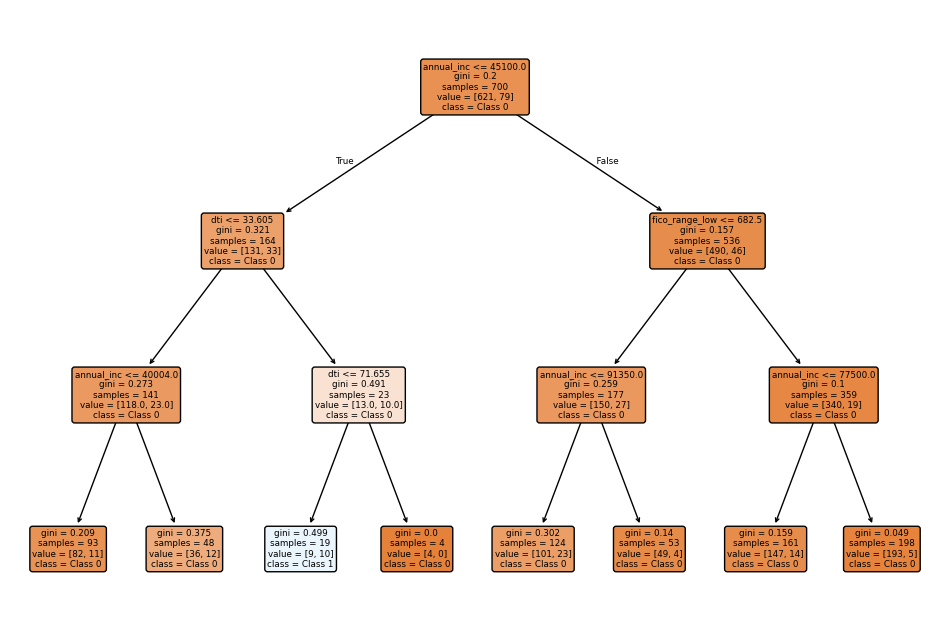

In [10]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(
        decision_tree,
        feature_names=X.columns,
        class_names=['Class 0', 'Class 1'],
        filled=True,
        rounded=True
        )

plt.show()


**Interpreting the plot:**

-   **Internal nodes:** Each node shows which feature is used for splitting, the threshold value, and the Gini impurity (a measure of how mixed the classes are at that point).
-   **Leaf nodes:** These represent the predicted class based on the features traversed.
-   **Color intensity:** The color intensity of the nodes reflects the degree of purity (the more homogeneous the classes are in a node, the deeper the color).

**Colour coding:**
The color intensity of each box reflects the **purity** of the node with respect to the target classes.  
-   **Pure Node:** If all the samples in a node belong to a single class, the node will have a deep, intense color. A pure node is one where the majority (or all) of the data points belong to one class.  
-   **Impure Node:** If the samples are evenly split between classes, the color will be lighter or more faded, indicating mixed classes at that node.

## 0.3\. **Picking the depth of a tree**
**Max Depth:** The depth of a decision tree is a critical hyperparameter that controls how many splits the tree can make from the root to a leaf.
-   **Shallow Trees (Low Depth):** Tend to underfit the data, as they are too simple and may not capture important patterns.
-   **Deep Trees (High Depth):** Tend to overfit the data, as they may capture noise in the training data, leading to poor generalization.-   
    
**How to Choose Depth:**
-   Use cross-validation to find the optimal depth that balances model performance and overfitting.
-   A common approach is to plot the tree depth against the model's accuracy on both training and validation sets. The goal is to find a depth where validation accuracy stabilizes or starts to drop (indicating overfitting).

In [11]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score

# List to store AUC values
train_auc = []
test_auc = []

# Range of depths to evaluate
depth_range = np.arange(1, 10)

# Loop over each depth
for depth in depth_range:
    # Initialize Decision Tree with the current max depth
    decision_tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    
    # Fit the model on training data
    decision_tree.fit(X_train, y_train)
    
    # Predict probabilities for the ROC AUC calculation
    y_train_pred_prob = decision_tree.predict_proba(X_train)[:, 1]
    y_test_pred_prob = decision_tree.predict_proba(X_test)[:, 1]
    
    # Calculate ROC AUC for both training and test sets
    train_auc.append(roc_auc_score(y_train, y_train_pred_prob))
    test_auc.append(roc_auc_score(y_test, y_test_pred_prob))


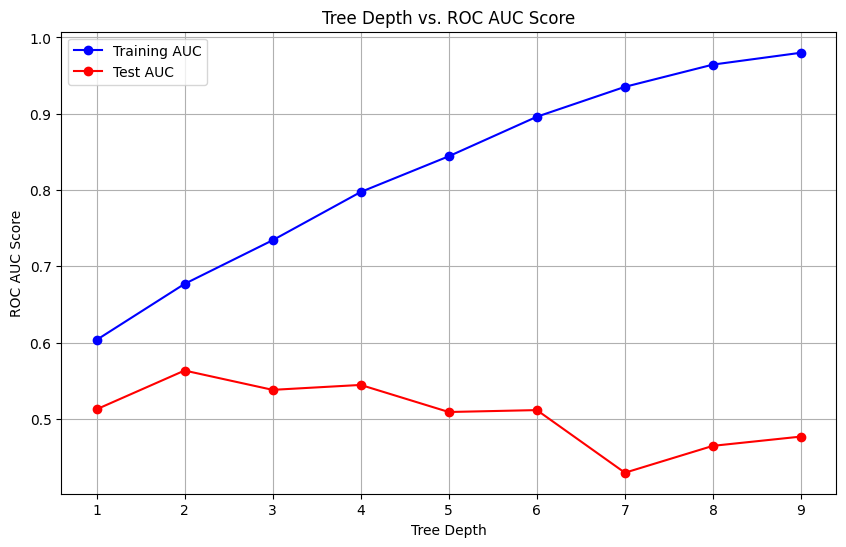

In [12]:
# Plotting the ROC AUC scores for training and validation sets
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(depth_range, train_auc, label='Training AUC', marker='o', color='blue')
plt.plot(depth_range, test_auc, label='Test AUC', marker='o', color='red')

# Adding labels and title
plt.xlabel('Tree Depth')
plt.ylabel('ROC AUC Score')
plt.title('Tree Depth vs. ROC AUC Score')
plt.legend()
plt.grid(True)
plt.show()

### <span style="color:BLUE"> >>> DISCUSSION:
> At what depth would you stop?

# 1. Ensemble Models in Machine Learning

## 1.1 Introduction to Ensemble Models

**What are Ensemble Models?**

Ensemble models combine multiple individual models (often referred to as "weak learners") to produce a more robust and accurate prediction. The idea is similar to taking the average opinion of multiple experts rather than relying on just one.

**Why use Ensemble Models?**
- **Improved Accuracy:** By combining the strengths of multiple models, ensemble models often outperform individual models.
- **Reduced Overfitting:** Since ensemble methods aggregate predictions, they can mitigate the risk of overfitting to the training data.
  
**Types of Ensemble Models**

1. **Bagging**
   - **Concept:** Bagging involves training multiple models independently using different subsets of the data and averaging their predictions. It’s particularly effective in reducing variance.
   - **Popular model:** Random Forest

2. **Boosting**
   - **Concept:** Boosting builds models sequentially, where each model tries to correct the errors of the previous one. The final prediction is a weighted sum of all models' predictions, which reduces both bias and variance.
   - **Popular model:** Gradient Boosting Trees (GBT), CatBoost

## 1.2 Popular ensemble models

**Gradient Boosting Trees (GBT):**

- **How it works:** GBT builds trees one at a time, where each new tree focuses on correcting the errors made by the previous ones. It's very powerful for tabular data.
- **Pros and Cons:**
  - **Pros:** High predictive accuracy, handles different data types well.
  - **Cons:** Can be slow to train, prone to overfitting if not tuned properly.

**CatBoost:**

- **How it works:** CatBoost is a form of gradient boosting that is particularly popular due to its predictive performance, and the fact that it handles categorical features without needing preprocessing.
- **Pros and Cons:**
  - **Pros:** Handles categorical data without preprocessing, robust against overfitting, fast to train.
  - **Cons:** Can be complex to tune.



## 1.3 Implementing a simple ensemble model using the same features selected in the prior session
Let's start with a **Random Forest classifier**.

In [13]:
# Initialize and train the Logistic Regression model
from sklearn.impute import SimpleImputer

# RandomForestClassifier model in scikit-learn cannot handle missing values represented as NaN (Not a Number), hence replacing
# Create an imputer (replace missing values with the mean of the column,
imputer = SimpleImputer(strategy='mean')

# Fit the imputer
X = imputer.fit_transform(X)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (again, given imputer used above)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [15]:
# Make predictions
rf_y_pred = rf.predict(X_test)
rf_y_prob = rf.predict_proba(X_test)[:,1]

model_evaluation_report(X_test, y_test, rf_y_pred, rf_y_prob)

Accuracy: 0.83
Precision: 0.09090909090909091
Recall: 0.023809523809523808
F1-Score: 0.03773584905660377
ROC-AUC: 0.5133351790328534
Confusion Matrix:
[[248  10]
 [ 41   1]]


### <span style="color:BLUE"> >>> DISCUSSION:
> How is this confusion metric different from the one built earlier?

## 1.4 Let's step up our game by increasing the number of features used

Increasing the number of features used in a machine learning model can have both potential benefits and drawbacks. Understanding the trade-offs is essential for optimizing model performance.

### Reasons to increase the number of features:
- More features can capture more details and nuances in the data, potentially leading to **better predictive performance**.
- In complex datasets, **interactions between features** may be important for prediction. A larger number of features increases the likelihood of capturing these interactions.
- A model with more features can **adapt** to a wider range of scenarios, potentially improving its performance across different subsets of data.
- More features can help **reduce bias** by providing the model with more information, thus allowing it to better fit the true underlying distribution of the data.
        
### Risks to be managed when increasing number of features
- **Curse of Dimensionality:** As the number of features increases, the data becomes more sparse, which can make it harder for the model to learn effectively Adding too many features can lead to **overfitting**, where the model becomes too tailored to the training data and performs poorly on new, unseen data.
- More features increase the **computational complexity**, leading to longer training times and requiring more computational resources.
- **Interpretability**, more features make it harder to understand how the model makes predictions.
- **Feature Redundancy:** Some features may be highly correlated, leading to redundancy and not adding much value to the model.    
    

### How to balance benefits and risks in practice?
The decision to increase the number of features should be based on a careful analysis of the trade-offs between model complexity, interpretability, computational cost, and predictive performance. In practice, it's often beneficial to start with a smaller, more manageable feature set, and then gradually add features while monitoring the model's performance.


### Let's put this in practice on the Lending Club case

In [16]:
print(f"Starting dataset has {len(df.columns)} columns.")

Starting dataset has 160 columns.


The first question we should pose ourself is: do we need all of the features?  
And the answer is NO. Let's understand why..

## 1.5 Feature selection
Feature selection is a crucial step in building machine learning models, especially when dealing with a large number of features. It helps in improving the model's performance by removing irrelevant or redundant features, reducing overfitting, and decreasing computation time.

### Approaches:
-   **Low variance feature removal:** Removes features with little to no variability across samples, as they contribute minimally to model prediction.
-   **Univariate feature selection:** Selects features based on statistical tests (e.g., chi-squared, ANOVA) that measure the relationship between each feature and the target variable independently.
-   **Recursive Feature Elimination (RFE):** Iteratively removes the least important features by fitting the model multiple times and pruning features with the lowest importance scores.
-   **Sequential feature selection:** Adds or removes features sequentially, starting from an empty set or full set, to find the combination that optimizes model performance based on a scoring metric.

Further reading: [scikit learn](https://scikit-learn.org/stable/modules/feature_selection.html)
______


In this session, we are going to leverage automatic feature selection via Recursive Feature Elimination, as provided by scikit learn, after doing some initial cleaning.


In [17]:
# Let's start reducing the number of features..

# Then, let's drop non-numeric features, for illustrative purposes only 
# *********** NOTE **************
# In your assignment you should include them and treat them accordingly
# (see 'Feature encoding' in session 3)
df_numeric = df.select_dtypes(exclude=['object'])\
                .drop(columns=['id', 
                             'loan_id_extracted'])
print(f"Number of columns: {len(df_numeric.columns)}")


Number of columns: 119


In [18]:
# Then, let's drop columns with high percentage of missing values
# *********** NOTE **************
# In a real-life scenario, we would want to understand data and make sure we are not discarding
# useful information before doing this!
threshold = 0.5 # Customisable
null_percentages = df_numeric.isnull().mean()
df_dropped = df_numeric.drop(columns=null_percentages[null_percentages > threshold].index)
print(f"Dropped columns: {null_percentages[null_percentages > threshold].index.tolist()}")
print(f"Number of columns: {len(df_dropped.columns)}")



Dropped columns: ['mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'deferral_term', 'hardship_amount', 'hardship_length', 'hardship_dpd', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount']
Number of columns: 94


**Note:** realistically we would like to retain some of the above columns - for example, `mths_since_last_delinq` could be a very important one where missing data might mean 'no delinquencies', so we may consider replacing with a value of 0. Additionally, we may want to add a `mths_since_last_delinq_MISSING_FLAG` that captures cases where that 0 was assigned manually.

In [19]:
# Then, we remove features that would not be available at time of application
# e.g.: total_pymnt which is defined as 'Payments received to date for total amount funded'
# This is to prevent phenomenom called 'data leakage', covered later in this notebook.
df_dropped = df_dropped.drop(columns = ["out_prncp",
                             "out_prncp_inv",
                             "total_pymnt",
                             "total_pymnt_inv",
                             "funded_amnt",
                             "funded_amnt_inv"]
                            ).drop(columns = ["dti"]) # Duplicate column

print(f"Number of columns: {len(df_dropped.columns)}")

Number of columns: 87


## 1.6 Null replacement strategies for remaining columns
### <span style="color:RED"> NOTE:  </span> Some very strong assumptions here, for illustrative purposes only. For your project/assignments, make sure that any replacement strategy is understood.

In [20]:
#########################################
# Group 1: Columns to be filled with 0 
# Assuming these features represent counts or amounts where a missing value means zero
fill_zero_cols = [
    'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m',
    'open_act_il', 'open_il_12m', 'open_il_24m',
    'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
    'all_util', 'inq_fi', 'total_cu_tl', 'acc_open_past_24mths',
    'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
    'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
    'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 
    'inq_last_12m', 'pub_rec_bankruptcies'
]
df_dropped[fill_zero_cols] = df_dropped[fill_zero_cols].fillna(0)

#########################################
# Group 2: Columns to be filled with median 
# (Assuming these features are numeric and can have a central tendency)
fill_median_cols = [
    'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct',
    'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
    'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
    'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tot_hi_cred_lim',
    'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'total_rev_hi_lim'
]
df_dropped[fill_median_cols] = df_dropped[fill_median_cols].apply(lambda x: x.fillna(x.median()))

#########################################
# Group 3: Fill with 999
fill_nine_cols = [
     'mths_since_rcnt_il'
]
# Apply fill with 999
df_dropped[fill_nine_cols] = df_dropped[fill_nine_cols].fillna(999)

#########################################
# Do a quick check on null values
df_dropped.columns[df_dropped.isna().sum() > 0]


Index(['last_pymnt_amnt_log'], dtype='object')

### Infinite replacement

In [21]:
def check_infinity(df):
    infinite_list = df.isin([-np.inf, np.inf]).sum()

    if infinite_list.sum() == 0:
        print("No column has infinite values")
    else:
        print("Columns with infinite values:")
        print(infinite_list[infinite_list>0])

check_infinity(df_dropped)

Columns with infinite values:
debt_to_income    1
dtype: int64


In [22]:
df_dropped[df_dropped["debt_to_income"].isin([-np.inf, np.inf])][["annual_inc", "loan_amnt", "debt_to_income"]]

,annual_inc,loan_amnt,debt_to_income
12439,0.0,10000.0,inf


In [23]:
df_dropped["debt_to_income"].describe()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    1000.000000
mean             inf
std              NaN
min         0.004878
25%         0.132225
50%         0.200000
75%         0.300000
max              inf
Name: debt_to_income, dtype: float64

In [24]:
df_dropped["debt_to_income"] = df_dropped["debt_to_income"].replace(np.inf, 999)

check_infinity(df_dropped)

No column has infinite values


In [25]:
# Export df_dropped following NA replacement
df_dropped.to_csv(f"{path_python_material}/data/2-intermediate/df_out_dsif6.csv"
                        , index = False)

In [26]:
# Then, let's drop the target variable from X
X = df_dropped.drop(columns=['loan_default'])
y = df_dropped['loan_default']
X_columns = X.columns
print(f"Number of columns: {len(X_columns)}")

# RandomForestClassifier model in scikit-learn cannot handle missing values represented as NaN (Not a Number), hence replacing
# Create an imputer (replace missing values with the mean of the column,
imputer = SimpleImputer(strategy='mean')
# Fit the imputer
X = pd.DataFrame(imputer.fit_transform(X)) # fit_transform returns an array, dataframe needed for Step 4

# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Number of columns: 86


In [27]:
# Step 2: Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)


In [28]:
# Step 3: Apply Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFE

rfe = RFE(estimator=rf,
          n_features_to_select=20, # n_features_to_select = number of features to select
          step=30,                  # step=1 means remove one feature at a time
          verbose = 3)

# Fit RFE to the training data
rfe.fit(X_train, y_train)



Fitting estimator with 86 features.
Fitting estimator with 56 features.
Fitting estimator with 26 features.


RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=20,
    step=30, verbose=3)

In [29]:
# Step 4: Select the top features
selected_features = X_train.columns[rfe.support_]
selected_features_names = X_columns[selected_features]
print("Selected Features by RFE:")
print(f"Index: {selected_features}")
print(f"Column names: {selected_features_names}")

Selected Features by RFE:
Index: Index([1, 10, 11, 12, 14, 15, 16, 17, 18, 35, 42, 45, 46, 50, 51, 66, 74, 75,
       78, 83],
      dtype='int64')
Column names: Index(['installment', 'total_acc', 'total_rec_prncp', 'total_rec_int',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt',
       'last_fico_range_high', 'last_fico_range_low', 'total_rev_hi_lim',
       'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mths_since_recent_bc', 'mths_since_recent_inq', 'pct_tl_nvr_dlq',
       'last_pymnt_amnt_log', 'last_pymnt_amnt_capped', 'debt_to_income',
       'annual_inc_std'],
      dtype='object')


In [30]:
# Step 5: Train the Random Forest classifier on the selected features
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train[selected_features], y_train)


RandomForestClassifier(random_state=42)

In [31]:
# Step 6: Evaluate the model performance on the test set
y_pred_selected = rf_selected.predict(X_test[selected_features])
y_prob_selected = rf_selected.predict_proba(X_test[selected_features])[:,1]




In [32]:
model_evaluation_report(X_test[selected_features], y_test, y_pred_selected, y_prob_selected)

Accuracy: 0.9733333333333334
Precision: 1.0
Recall: 0.8095238095238095
F1-Score: 0.8947368421052632
ROC-AUC: 0.9766057585825028
Confusion Matrix:
[[258   0]
 [  8  34]]


### <span style="color:BLUE"> >>> DISCUSSION:</span>
This performance is good.. maybe even suspiciously too good... what can have happened here??


In [ ]:
# Plot pair wise correlation:
import seaborn as sns
target = 'loan_default'
flag_plot = False

for col in selected_features_names:
    # Calculate correlation
    correlation = df_dropped[[col, target]].corr().iloc[0, 1]
    
    print(f"Correlation between {col} and {target}: {correlation:.2f}")
    # Create scatter plot
    if flag_plot:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=df_dropped[col], y=df_dropped[target])

        # Add title with correlation value
        plt.xlabel(col)
        plt.ylabel(target)
        # Show plot
        plt.show()
    

### <span style="color:BLUE"> >>> DISCUSSION: 
> What do you think is happening for `Correlation between recoveries and loan_default` and `Correlation between collection_recovery_fee and loan_default`?

### **Data leakage** (or **target leakage**)  
Occurs when a feature includes information that would not be available at prediction time, often because it is generated after or is causally linked to the outcome (e.g., using recovery amounts to predict defaults).

#### Example in our case:
For predicting defaults, using **recovery** data would be an example of **data leakage** because recovery occurs after the default event, making it intrinsically correlated with the outcome you're trying to predict (default). In this case, the model is being trained on information that would not be available at the time of making the prediction, leading to overfitting and unrealistic performance.

#### How to address it:
-   Remove or avoid using features that represent **future information** or data that is directly derived from the target variable.
-   Ensure that predictors are limited to features that would be available **before** the target event occurs (in your case, before the default).

In [ ]:
X = df_dropped.drop(columns=['loan_default', "recoveries", "collection_recovery_fee"])
y = df_dropped['loan_default']
X_columns = X.columns
print(f"Number of columns: {len(X_columns)}")

# RandomForestClassifier model in scikit-learn cannot handle missing values represented as NaN (Not a Number), hence replacing
# Create an imputer (replace missing values with the mean of the column,
imputer = SimpleImputer(strategy='mean')
# Fit the imputer
X = pd.DataFrame(imputer.fit_transform(X)) # fit_transform returns an array, dataframe needed for Step 4

# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 2: Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 3: Apply Recursive Feature Elimination (RFE)
rfe = RFE(estimator=rf,
          n_features_to_select=20, # n_features_to_select = number of features to select
          step=30,                  # step=1 means remove one feature at a time
          verbose = 3)

# Fit RFE to the training data
rfe.fit(X_train, y_train)

# Step 4: Select the top features
selected_features = X_train.columns[rfe.support_]
selected_features_names = X_columns[selected_features]
print("Selected Features by RFE:")
print(f"Index: {selected_features}")
print(f"Column names: {selected_features_names}")

# Step 5: Train the Random Forest classifier on the selected features
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train[selected_features], y_train)

# Step 6: Evaluate the model performance on the test set
y_pred_selected = rf_selected.predict(X_test[selected_features])
y_prob_selected = rf_selected.predict_proba(X_test[selected_features])[:,1]




In [ ]:
model_evaluation_report(X_test, y_test, y_pred_selected, y_prob_selected)

2\. Model Interpretability and Explainability Frameworks
--------------------------------------------------------

### 2.1 The Challenge of Interpretability in Finance

Ensemble models, particularly those that involve many weak learners like GBT or Random Forest, are often seen as "black boxes." While they provide high accuracy, their complexity makes it difficult to understand how they arrive at a specific decision. This lack of transparency can be problematic in finance, where understanding the "why" behind a model's prediction is as important as the prediction itself.

### 2.2 Techniques for Interpreting Models

**Feature Importance:**

One of the simplest methods to interpret an ensemble model is to look at the feature importance scores. These scores tell us which features the model found most relevant for making predictions.

**SHAP (SHapley Additive exPlanations):**

SHAP is a game-theory-based method that provides a consistent and unified measure of feature importance. Unlike simple feature importance, SHAP values give insight into how each feature impacts the model's predictions for individual instances.



### Visualizing Feature importance

Let's see how we can visualize feature importance in our Random Forest model.

In [ ]:
import matplotlib.pyplot as plt

importances = rf_selected.feature_importances_
print(type(importances))


In [ ]:
# Sort the array in descending order
indices = np.argsort(importances)[::-1]
# argsort > returns the indices of the importances array in ascending order.
# [::-1]  > reverses the array, making the sorting descending.
# It uses Python's slice notation, where the syntax is [start:stop:step]

col_labels = X_columns[X[selected_features].columns[indices]]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X[selected_features].shape[1]), importances[indices], align="center")
plt.xticks(ticks = range(X[selected_features].shape[1])
           , labels = col_labels, rotation=90)
plt.tight_layout()
plt.show()

**Further reading**: See the following articles [this medium article]() for examples on how SHAP can be used instead.
- [Medium link](https://medium.com/@anshulgoel991/model-exploitability-using-shap-shapley-additive-explanations-and-lime-local-interpretable-cb4f5594fc1a) (interestingly, also on a random forest classifier :)  )
- [Datacamp link](https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability)


### Visualising SHAP values

In [ ]:
import shap

# SHAP TreeExplainer for RandomForestClassifier
rf_explainer = shap.TreeExplainer(rf_selected)
rf_shap_values = rf_explainer.shap_values(X_test)

# Check SHAP values' shape to confirm
print(f'RF SHAP values shape: {rf_shap_values[1].shape}')


In [ ]:
# Initialize JS visualization for interactive plots
shap.initjs()

In [ ]:
observation_index = 7
# Step 1 - calculate expected value of positive class
# This is baseline or average prediction of the model for the positive class before any specific features for an observation are considered
expected_value_positive_class = rf_explainer.expected_value[1]
print("expected_value_positive_class:", expected_value_positive_class)

# Step 2 - SHAP plot for a specific observation (e.g., the first row in the test set)
shap.force_plot(expected_value_positive_class
                ,  rf_shap_values[observation_index][:, 1] # shap_values_positive_class
                , X_test.iloc[observation_index])

This is good, but **let's make it interactive!**

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create a function to update SHAP visualizations based on selected observation
def update_shap_plot(observation_index):
    # Clear the previous output to avoid stacking multiple force plots
    clear_output(wait=True)
    
    # Re-display the slider (since clearing the output also clears the slider)
    display(observation_slider)
    
    feature_names = col_labels
    
    # Display SHAP force plot for the selected observation
    display(shap.force_plot(
            expected_value_positive_class
                , rf_shap_values[observation_index][:, 1] 
                , X_test.iloc[observation_index]
                , feature_names = feature_names
           ))

# Create a slider to select the observation (0 to len(X_test)-1)
observation_slider = widgets.IntSlider(
    value=0, min=0, max=len(X_test)-1, step=1, description='Observation:', continuous_update=True)

# Use the interactive function to update the SHAP plot when the slider value changes
observation_slider.observe(lambda change: update_shap_plot(change['new']), names='value')

# Display the slider and force plot
display(observation_slider)

# Call update_shap_plot to display the initial SHAP plot
update_shap_plot(0)

3\. Intro to Hyperparameter Tuning
----------------------------------

### 3.1 Why Hyperparameter Tuning?

Hyperparameters are settings that control the learning process of a model.  Unlike the model parameters (like weights), hyperparameters are not learned from the data; they need to be set manually or through a tuning process.


**Importance in ML:**
-   **Performance:** Properly tuned hyperparameters can dramatically improve model performance
-   **Overfitting:** Tuning can help in finding a balance between underfitting and overfitting

### 3.2 Methods for Hyperparameter Tuning

1.  **Grid Search:**
    -   **Concept:** Exhaustively search over a predefined set or range of hyperparameters
    -   **Pros:** Guarantueed best combination within the grid
    -   **Cons:** Computationally expensive
    
2.  **Random Search:**
    -   **Concept:** Randomly samples combinations of hyperparameters from the predefined range
    -   **Pros:** Often finds a good combination with less computational cost
    -   **Cons:** No guarantee of finding the absolute best combination

### <span style="color:BLUE"> **>>> DISCUSSION: Which parameters did we set earlier for our random forest models?**  </span>    

**Further resources**: More hyperparameters by common model type [here](https://www.researchgate.net/figure/A-comprehensive-overview-of-common-ML-models-their-hyper-parameters-suit-able_tbl2_343390531)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters grid
param_grid = {
    'n_estimators': [50, 200],    # [50, 100, 200],
    'max_depth': [3, 10],      # [None, 10, 20, 30],
    'min_samples_split': [2]  # [2, 5, 10]
}

# Initialize Grid Search
grid_search = GridSearchCV(estimator=rf_selected,
                           param_grid=param_grid,
                           cv=2,
                           n_jobs=-1,
                           verbose=3)



In [ ]:
# Fit Grid Search
grid_search.fit(X_train[selected_features], y_train)


In [ ]:
# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')


In [ ]:
best_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)

# Step 2: Fit the model on the training data
best_rf.fit(X_train[selected_features], y_train)

# Step 3: Predict on the test set
y_pred = best_rf.predict(X_test[selected_features])
y_prob = best_rf.predict_proba(X_test[selected_features])[:,1]

model_evaluation_report(X_test[selected_features], y_test, y_pred, y_prob)


### <span style="color:BLUE"> >>> DISCUSSION:
> What do you think could be some of the challenges of this approach?
    

### <span style="color:BLUE"> **>>> EXERCISE 1 (optional) - SHAP value interpretation:**  </span>    
> Find an observation in your dataset for which the prediction is "1" (default). **What factors contributed to that** and is this aligned to expectations? **How would you explain it to a business stakeholder?**  

> Now repeat for an observation in your dataset for which the prediction is "0" (non default).

Feel free to bring your results for discussion in a future office hour.

### <span style="color:BLUE"> **>>> EXERCISE 2 (optional):**  </span> 

> Review and enhance the strategies adopted for **Feature selection** and **Null replacement** in the beginning of the notebook.  

> You will be able to leverage this work in the final assignment.


# End of session

In [ ]:
from IPython.display import Image
Image(filename=f"{path_python_material}/images/the-end.jpg", width=500,)


# Appendix

**Cat Boost implementation**

In [ ]:
from catboost import CatBoostClassifier

# Initialize the CatBoostClassifier with an overfitting detector
cb = CatBoostClassifier(
    iterations=500,      # Maximum number of boosting iterations
    learning_rate=0.05,  # Learning rate
    eval_metric='AUC',   # Metric to monitor
    early_stopping_rounds=20,  # Stop if no improvement after X iterations
    od_type='Iter',            # Overfitting detection type (detect after fixed number of non-improving iterations)
    random_seed=42,
    verbose=100                # Print log every X iterations
)

# Train the model with training and validation data
cb.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),  # Validation set for monitoring overfitting
    use_best_model=True,        # Use the best model from the iterations
    plot=True                   # Plot the learning curve
)
cb

In [ ]:
# Make predictions
cb_y_pred = cb.predict(X_test)
cb_y_prob = cb.predict_proba(X_test)[:, 1]

model_evaluation_report(X_test, y_test, cb_y_pred, cb_y_prob)
